In [1]:
import pickle as pkl
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
import torch
import random
from astropy.cosmology import Planck18
import glob
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
"""
    This function reads data from the original DESI and ZTF datasets that were provided, and matches observations with the same targetID.
    Then, filtering is optionally performed using errocodes from ZTF, and the DESI and ZTF datasets are combined into the format of a single JSON file.
    TODO: convert to numpy to make more efficient.
"""
def preprocess_data(path, dates_path, filter_zerr = True):
    num_rej = 0
    num_pass = 0
    targets = []

    dates = pd.read_hdf(dates_path)
    
    paths = glob.glob(path)
    
    for path in tqdm(paths):
        datafile = h5py.File(path, 'r')
        for key in datafile.keys():
            obs = {}
            for item in datafile[key].keys():
                obs_dict = {}
                for key2 in datafile[key][item].keys():
                    obs_dict[key2] = np.asarray(datafile[key][item][key2])
                obs[item] = obs_dict
                # obs[item] = datafile[key][item]
                
            ztf_slice = dates[dates["targetid"] == int(key)]
            if(len(ztf_slice) == 0):
                num_rej += 1
                continue
            elif(len(ztf_slice) > 0):
                ztf_slice = ztf_slice.iloc[0]
                
            DESI_date = np.asarray(ztf_slice["mjd"])

            if(filter_zerr and float(ztf_slice["zwarn"]) != 0):
                num_rej += 1
                continue


            obs["desi_date"] = DESI_date
            obs["targetid"] = key
            obs["z"] = float(ztf_slice["z"])
            obs["zerr"] = float(ztf_slice["zerr"])
            num_pass += 1
                
            targets.append(obs)
    print(f"{num_pass} samples successfully loaded and {num_rej / (num_rej + num_pass)} % of data had ztf data errors")
    return targets

In [3]:
def preprocess_data_parallel(path, dates_path, filter_zerr = True):
    dates = pd.read_hdf(dates_path)
    
    train = set(json.load(open("train_split.json"))["train"])
    def preprocess_data_parallel_node(dates, path, filter_zerr = True):
        num_rej = 0
        num_pass = 0
        targets = []

        datafile = h5py.File(path, 'r')
        for key in datafile.keys():
            if not key in train:
                continue
            obs = {}
            for item in datafile[key].keys():
                obs_dict = {}
                for key2 in datafile[key][item].keys():
                    obs_dict[key2] = np.asarray(datafile[key][item][key2])
                obs[item] = obs_dict
                # obs[item] = datafile[key][item]

            ztf_slice = dates[dates["targetid"] == int(key)]
            if(len(ztf_slice) == 0):
                num_rej += 1
                continue
            elif(len(ztf_slice) > 0):
                ztf_slice = ztf_slice.iloc[0]

            DESI_date = np.asarray(ztf_slice["mjd"])

            if(filter_zerr and float(ztf_slice["zwarn"]) != 0):
                num_rej += 1
                continue


            obs["desi_date"] = DESI_date
            obs["targetid"] = key
            obs["z"] = float(ztf_slice["z"])
            obs["zerr"] = float(ztf_slice["zerr"])
            num_pass += 1

            targets.append(obs)

        return (num_rej, num_pass, targets)
    
    paths = glob.glob(path)
    results = Parallel(n_jobs=-1)(delayed(preprocess_data_parallel_node)(dates, path, filter_zerr) for path in tqdm(paths))
    
    output_list = []
    num_rej = 0
    num_pass = 0
    
    for output in results:
        output_list += output[2]
        num_rej += output[0]
        num_pass += output[1]
        
    print(f"{num_pass} samples successfully loaded and {num_rej / (num_rej + num_pass)} % of data had ztf data errors")
    return output_list

In [5]:
def trimLC(hmjd, mag, magerr, catflags):
    index = np.full(len(hmjd), False)
    index = np.logical_or(index, (catflags & 32768)==0)
    return hmjd[index], mag[index], magerr[index]

#This function filters data based on ZTF catflags
def filter_catflags(data_dict):
    total_len = 0
    removed_len = 0
    for obs in tqdm(data_dict):
        for key in ["g", "i", "r"]:
            if len(obs[key]) == 0:
                continue

            new_hmjd, new_mag, new_magerr = trimLC(obs[key]["hmjd"], obs[key]["mag"], obs[key]["magerr"], obs[key]["catflags"])
            total_len += len(obs[key]["hmjd"])
            removed_len += len(new_hmjd)
            obs[key].pop("catflags")

            obs[key]["hmjd"] = new_hmjd
            obs[key]["mag"] = new_mag
            obs[key]["magerr"] = new_magerr

    print(f"Data successfully filtered! {round((total_len - removed_len - 0.0)/total_len * 100, 3)}% of data had catflag errors")
    
#This function corrects magnitudes based on redshift, using the Planck18 cosmology from Astropy.
def correct_redshift(data_dict):
    for obs in tqdm(data_dict):
        for key in ["g", "i", "r"]:
            if len(obs[key]) == 0:
                continue
            mag = obs[key]["mag"]
            magerr = obs[key]["magerr"]

            z = obs["z"]
            zerr = obs["zerr"]
            cmag = []
            cmagerr = []

            for i in range(len(mag)):
                cmag.append(correctMag(mag[i], z))
                cmagerr.append(correctMagErr(magerr[i], z, zerr))

            obs[key]["mag"] = cmag
            obs[key]["magerr"] = cmagerr
            
#This function is the same as filter_catflags, but is parallelized using Joblib (multiprocessing)
def filter_catflags_parallel(data_dict):
    #process 100 observations from the data dict, starting from the given start location
    def filter_subpart(data_dict, start):
        total_len = 0
        removed_len = 0
        for i in range(start, start + 100):
            if(i >= len(data_dict)):
                break
            obs = data_dict[i]
            for key in ["g", "i", "r"]:
                if len(obs[key]) == 0:
                    continue

                new_hmjd, new_mag, new_magerr = trimLC(obs[key]["hmjd"], obs[key]["mag"], obs[key]["magerr"], obs[key]["catflags"])
                total_len += len(obs[key]["hmjd"])
                removed_len += len(new_hmjd)
                obs[key].pop("catflags")

                obs[key]["hmjd"] = new_hmjd
                obs[key]["mag"] = new_mag
                obs[key]["magerr"] = new_magerr
        return (total_len, removed_len)
    
    results = Parallel(n_jobs=-1, timeout = 99999)(delayed(filter_subpart)(data_dict, start*100) for start in tqdm(range(len(data_dict)//100+1)))
    
    removed_len = 0
    total_len = 0
    
    for output in results:
        num_rej += output[1]
        num_pass += output[0]
        
    print(f"Data successfully filtered! {round((total_len - removed_len - 0.0)/total_len * 100, 3)}% of data had catflag errors")


In [6]:
'''
    Given (magnitude, magerror, date) ZTF pairs, this computes the weighted average magnitude for all
    data points within a specified range (tolerance) of the provided DESI observation date.
'''
def weightedMean(data, weights, dates, obs_date, tolerance, flux = True):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

In [4]:
''' General utility functions for converting between magnitude and flux and computing distance modulus,
with functions for error propagation
'''
def fluxToMag(f):
    m  = -2.5 * np.log10(f)
    return m

def magToFlux(m):
    f = 10**(-0.4*m)
    return f

def fluxToMagErr(f, df):
    dm = np.abs(2.5 / np.log(10) * df / f)

    return dm

def magToFluxErr(m, dm):
    df = np.abs(dm * 10**(-0.4*m) * np.log(10)/-2.5)
    return df

mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def correctMag(m, z):
    dmod = distmodWithCache(z)
    return m - dmod

#empirically computes the error
def correctMagErr(merr, z, zerr):
    d_upper = distmodWithCache(z+zerr)
    d_lower = distmodWithCache(z-zerr)

    d_err = np.abs(d_upper - d_lower)/2
    return np.sqrt(merr**2+d_err**2)

In [7]:
#this function generates a plot of all of the ZTF observation magnitudes vs dates, while
#specially marking the DESI observation date.
def plot_with_desi_compare(data, err, dates, DESI_date, tolerance, targetID):
    wmean, wmean_err = weightedMean(data, err, dates, DESI_date, tolerance, False)
    wmean_f, wmean_err_f = weightedMean(data, err, dates, DESI_date, tolerance, True)
    if(wmean == None or wmean_f == None):
        return
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    fig.suptitle(f"ZTF Magnitude with Error for {targetID}")

    if(tolerance > 2000):
        ax.errorbar(dates, data, yerr = err, fmt="o", label = "ZTF Mag. w/ Error")
    else:
        inner_dates = [dates[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]
        inner_data = [data[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]
        inner_err = [err[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) < tolerance)]

        outer_dates = [dates[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]
        outer_data = [data[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]
        outer_err = [err[i] for i in range(len(dates)) if (np.abs(dates[i] - DESI_date) > tolerance)]

        if(len(inner_dates) > 0):
            ax.errorbar(inner_dates, inner_data, yerr = inner_err, fmt="o", label = "ZTF Mag. w/ Error")
        if(len(outer_dates) > 0):
            ax.errorbar(outer_dates, outer_data, yerr = outer_err, fmt="o", alpha = 0.5)



    ax.axhline(wmean, c = "orange", label = "Mean Mag. w/ Error")
    ax.axhline(wmean + wmean_err, c = "orange", linestyle = "--")
    ax.axhline(wmean - wmean_err, c = "orange", linestyle = "--")

    ax.axhline(wmean_f, c = "green", label = "Mean Mag. w/ Error (flux)")
    ax.axhline(wmean_f + wmean_err_f, c = "green", linestyle = "--")
    ax.axhline(wmean_f - wmean_err_f, c = "green", linestyle = "--")
    
    ax.axvline(DESI_date, c = "red", label = "DESI observation date w/window")
    if(tolerance < 2000):
        ax.axvline(DESI_date + tolerance, c = "red", linestyle = "--")
        ax.axvline(DESI_date - tolerance, c = "red", linestyle = "--")
    fig.legend()

In [8]:
#this is a wrapper funciton for plot_with_desi_compare, that randomly selects observations from a given
#data_dict to plot.
def generate_plots_compare(data_dict, n, tolerance):
    for i in range(n):
        field = random.choice(data_dict)

        for channel in ["g", "i", "r"]:
            obs = field[channel]
            if(len(obs) == 0):
                continue
            DESI_date = field["desi_date"]
            mag = obs["mag"]
            magerr = obs["magerr"]
            date = obs["hmjd"]

            plot_with_desi_compare(mag, magerr, date, DESI_date, tolerance, field["targetid"])
            break

In [21]:
data = preprocess_data_parallel("/global/cfs/projectdirs/desi/users/akim/Projects/QSO_Distance/data/lc/*", "/global/cfs/projectdirs/desi/users/akim/Projects/QSO_Distance/data/dates.hdf5")


100%|██████████| 1174/1174 [12:34<00:00,  1.56it/s]


1292763 samples successfully loaded and 0.02634472661104341 % of data had ztf data errors


In [22]:
with open('train_preprocessed.pkl', 'wb') as f:
    pkl.dump(data, f)

In [9]:
with open('train_preprocessed.pkl', 'rb') as f:
    data = pkl.load(f)

KeyboardInterrupt: 

In [54]:
filter_catflags(data)




  0%|          | 0/1292763 [00:00<?, ?it/s]


  0%|          | 3133/1292763 [00:00<00:41, 31324.50it/s]


  1%|          | 9127/1292763 [00:00<00:26, 48152.72it/s]


  1%|▏         | 16184/1292763 [00:00<00:21, 58381.50it/s]


  2%|▏         | 22023/1292763 [00:00<00:22, 56692.54it/s]


  2%|▏         | 27700/1292763 [00:00<00:23, 54628.44it/s]


  3%|▎         | 33956/1292763 [00:00<00:21, 57223.24it/s]


  3%|▎         | 40790/1292763 [00:00<00:20, 60762.56it/s]


  4%|▍         | 49387/1292763 [00:00<00:18, 68646.41it/s]


  4%|▍         | 56664/1292763 [00:00<00:17, 69917.77it/s]


  5%|▍         | 63678/1292763 [00:01<00:18, 68092.88it/s]


  5%|▌         | 70512/1292763 [00:01<00:18, 67649.21it/s]


  6%|▌         | 78431/1292763 [00:01<00:17, 71078.95it/s]


  7%|▋         | 85559/1292763 [00:01<00:17, 69170.93it/s]


  7%|▋         | 92499/1292763 [00:01<00:17, 69224.16it/s]


  8%|▊         | 99438/1292763 [00:01<00:17, 67534.95it/s]


  8%|▊         | 106209/1292763 [00:01

Data successfully filtered! 4.276% of data had catflag errors


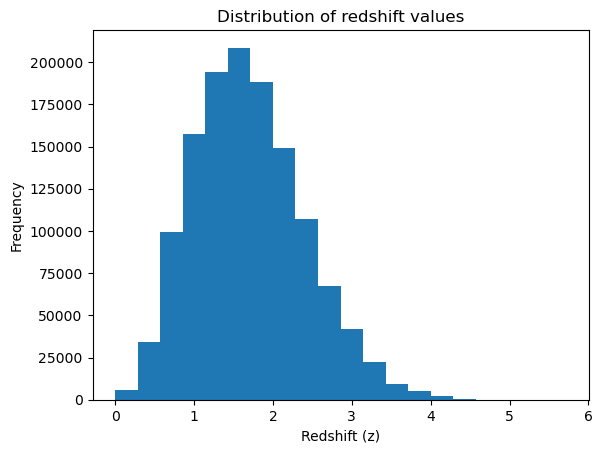

In [55]:
redshifts = [obs["z"] for obs in data]
plt.hist(redshifts, bins = 20)
plt.title("Distribution of redshift values")
plt.xlabel("Redshift (z)")
plt.ylabel("Frequency")
plt.show()


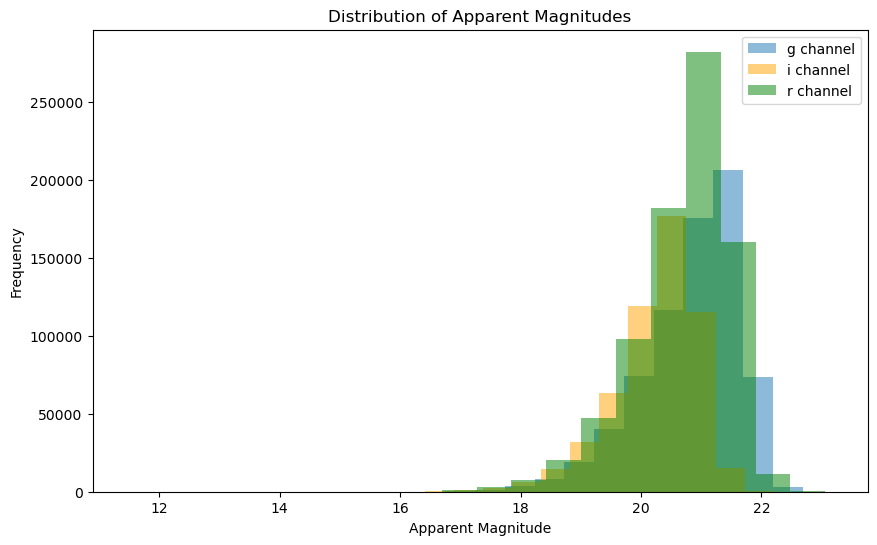

In [56]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in data:
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 20)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 20)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 20)

plt.title("Distribution of Apparent Magnitudes")
plt.xlabel("Apparent Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [59]:
# dates = pd.read_hdf("../../data/dates.hdf5")
# dates

In [60]:
correct_redshift(data)




  0%|          | 0/1292763 [00:00<?, ?it/s]


  0%|          | 91/1292763 [00:00<23:47, 905.71it/s]


  0%|          | 196/1292763 [00:00<21:45, 990.29it/s]


  0%|          | 307/1292763 [00:00<20:46, 1037.12it/s]


  0%|          | 411/1292763 [00:00<21:31, 1000.62it/s]


  0%|          | 512/1292763 [00:00<24:06, 893.22it/s] 


  0%|          | 603/1292763 [00:00<25:33, 842.44it/s]


  0%|          | 689/1292763 [00:00<27:01, 797.02it/s]


  0%|          | 770/1292763 [00:00<27:55, 770.89it/s]


  0%|          | 848/1292763 [00:01<29:14, 736.16it/s]


  0%|          | 923/1292763 [00:01<29:34, 727.93it/s]


  0%|          | 997/1292763 [00:01<30:09, 714.06it/s]


  0%|          | 1069/1292763 [00:01<30:08, 714.33it/s]


  0%|          | 1161/1292763 [00:01<27:55, 771.07it/s]


  0%|          | 1239/1292763 [00:01<27:57, 770.03it/s]


  0%|          | 1334/1292763 [00:01<26:17, 818.45it/s]


  0%|          | 1417/1292763 [00:01<27:18, 788.30it/s]


  0%|          | 1506/1292763 [0

In [61]:
with open('train_redshifted.pkl', 'wb') as f:
    pkl.dump(data, f)

In [9]:
with open('train_redshifted.pkl', 'rb') as f:
    data = pkl.load(f)

100%|██████████| 1292763/1292763 [00:01<00:00, 715466.24it/s]


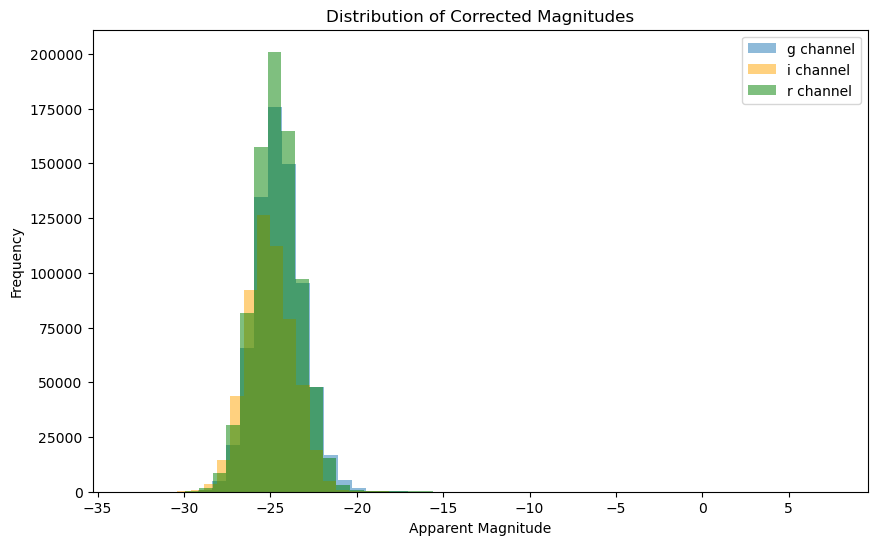

In [11]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in tqdm(data):
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 50)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 50)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 50)

plt.title("Distribution of Corrected Magnitudes")
plt.xlabel("Apparent Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# data[0]

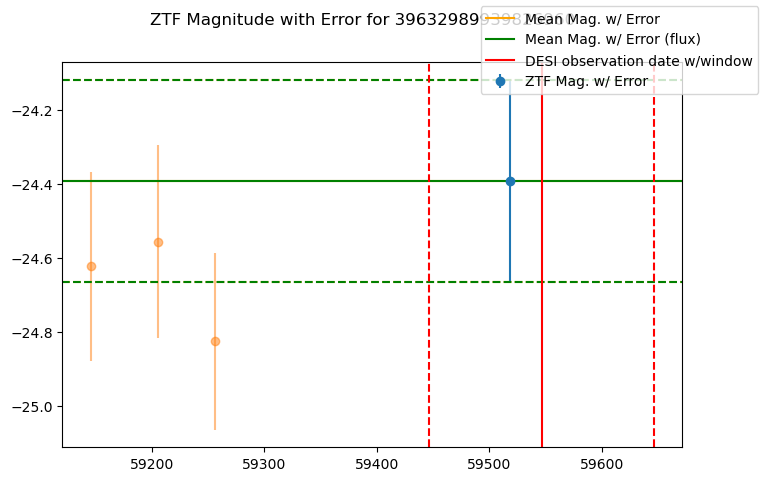

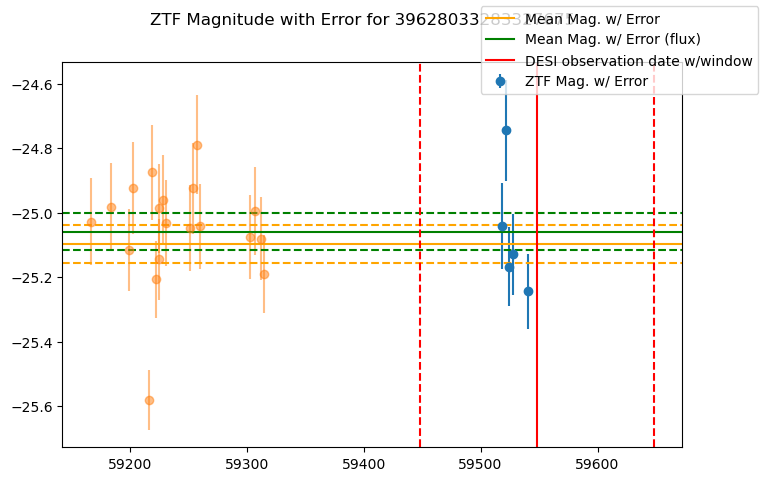

In [68]:
generate_plots_compare(data, 3, 100)

100%|██████████| 1292763/1292763 [03:27<00:00, 6240.54it/s] 


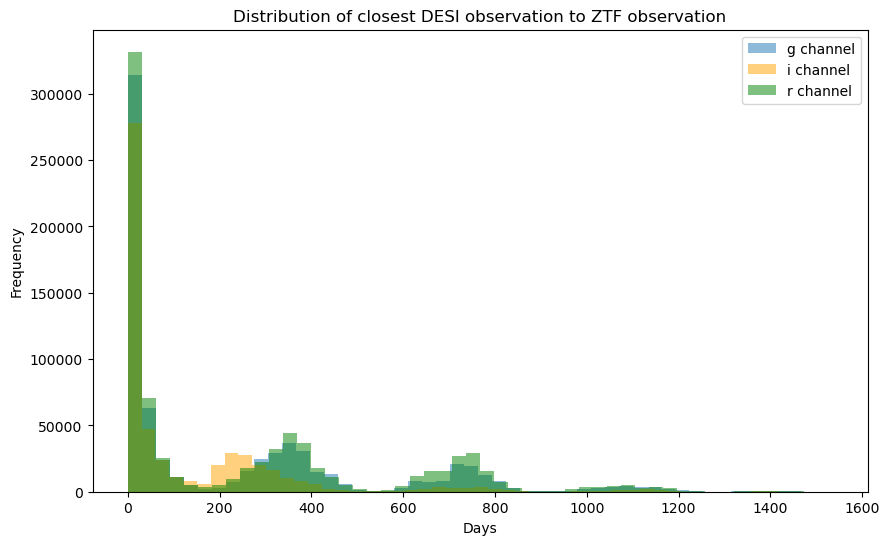

In [10]:
closest_dates = {"g": [], "i": [], "r": []}
for obs in tqdm(data):
    ztf_date = obs["desi_date"]
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = min([np.abs(date - ztf_date) for date in obs[ch]["hmjd"]])
        closest_dates[ch].append(closest_date)

plt.figure(figsize=(10,6))
plt.hist(closest_dates["g"], alpha = 0.5, label = "g channel", bins = 50)
plt.hist(closest_dates["i"], alpha = 0.5, label = "i channel", color = "orange", bins = 50)
plt.hist(closest_dates["r"], alpha = 0.5, label = "r channel", color = "green", bins = 50)

plt.title("Distribution of closest ZTF observation to DESI observation")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.legend()
plt.show()


100%|██████████| 1292763/1292763 [00:02<00:00, 549879.36it/s]


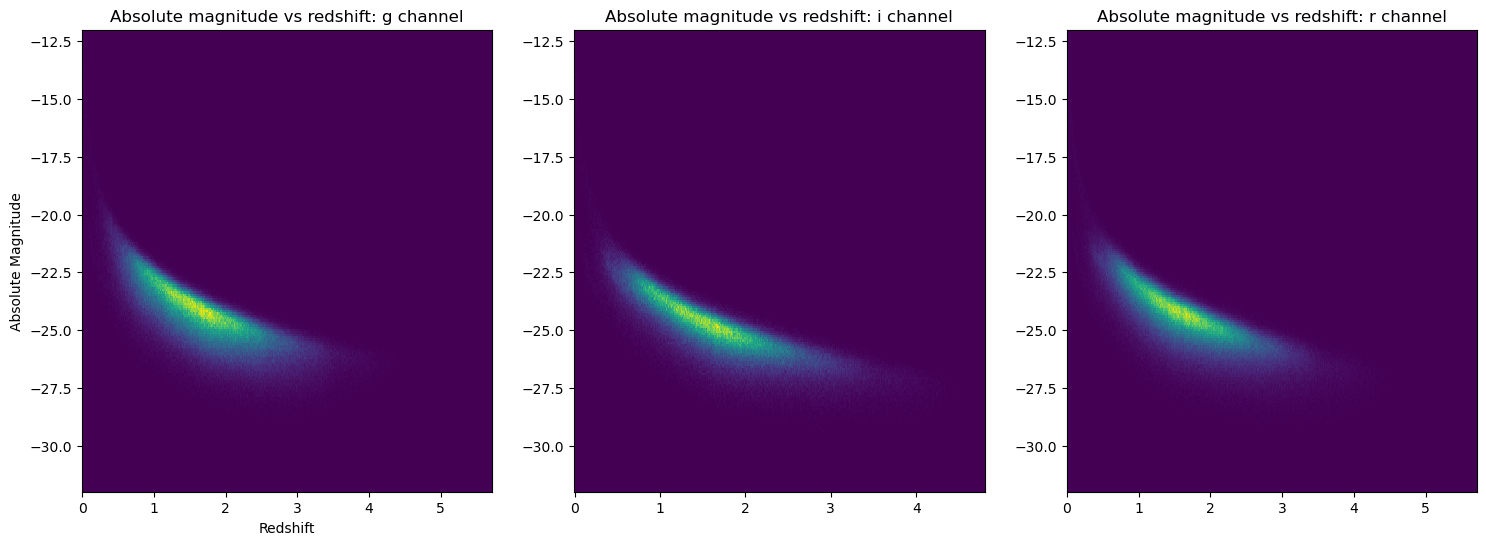

In [12]:
#we want to plot the density distribution of (absolute magnitude vs redshift) observations for each channel.
closest_dates = {"g": [], "i": [], "r": [], "gr":[], "ir":[], "rr":[]}

for obs in tqdm(data):
    for ch in ["g", "i", "r"]:
        if(len(obs[ch]) == 0):
            continue

        closest_date = obs[ch]["mag"][0]
        closest_dates[ch].append(closest_date)
        redshift = obs["z"]
        closest_dates[ch + "r"].append(redshift)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].hist2d(closest_dates["gr"], closest_dates["g"], label = "g channel", bins = 400)
ax[1].hist2d(closest_dates["ir"], closest_dates["i"], label = "i channel", bins = 400)
ax[2].hist2d(closest_dates["rr"], closest_dates["r"], label = "r channel", bins = 400)

ax[0].set_title("Absolute magnitude vs redshift: g channel")
ax[1].set_title("Absolute magnitude vs redshift: i channel")
ax[2].set_title("Absolute magnitude vs redshift: r channel")

ax[0].set_ylim(-32, -12)
ax[1].set_ylim(-32, -12)
ax[2].set_ylim(-32, -12)

ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Absolute Magnitude")
plt.show()

## Initial attempt at Numpyro MCMC

In [10]:
import numpyro

import numpyro.distributions as dist
from jax import random

from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")

def calc_dispersion_bayesian(mag, magerr, dates, obs_date = 0, threshold = float("inf")):
    #Optionally restrict data to data that is within a specified date range. In practice, this is not used.
    #Inputs: mag/magerr are the average magnitude/magnitude error of different targetIDs.
    f_mag = []
    f_magerr = []
    for i in range(len(mag)):
        if(np.abs(dates[i] - obs_date) < threshold):
            f_mag.append(mag[i])
            f_magerr.append(magerr[i])

    f_mag = np.array(f_mag)
    f_magerr = np.array(f_magerr)

    mean_mag, _= weightedMean(mag, magerr, dates, obs_date, threshold)
    
    def simulate_measurement(J, measurement_err, y = None):
        #parameters are mean magnitude, intrinsic dispersion 
        disp = numpyro.sample("dispersion", dist.HalfCauchy(0.5))
        mean_mag_o = numpyro.sample("Mean Magnitude", dist.Normal(mean_mag))
        with numpyro.plate('J', J):
            #compare sampled magnitude with true magnitude.
            act_mag = numpyro.sample("true_mag", dist.Normal(mean_mag_o, disp))

            numpyro.sample('obs', dist.Normal(act_mag, measurement_err), obs=y)

    nuts_kernel = NUTS(simulate_measurement)
    mcmc = MCMC(nuts_kernel, num_warmup=600, num_samples=4000, num_chains=1, progress_bar = False)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, len(f_mag), f_magerr, y=f_mag, extra_fields=('potential_energy',))
    # mcmc.print_summary()
    # print(mcmc.get_samples())
    return mcmc.get_samples()["dispersion"][-1]

In [11]:
def weightedMean(data, weights, dates, obs_date = 0, tolerance = float("inf"), flux = True):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

In [12]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    channel = obs["g"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

100%|██████████| 1292763/1292763 [03:07<00:00, 6883.00it/s] 


In [13]:
groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))

100%|██████████| 721559/721559 [00:01<00:00, 454832.10it/s]


In [14]:
def dispersion_subset(input_tuple):
    smags = input_tuple[0]
    smagerr = input_tuple[1]
    sdates = input_tuple[2]

    
    return calc_dispersion_bayesian(smags, smagerr, sdates)
        

In [15]:
def calculate_dispersion_with_batching(mag, magerr, dates, batch_size = 1000, margin = 0.05):
    
    num_groups = (int)(len(mag) / batch_size)
    split_mags = [[] for i in range(num_groups)]
    split_magerr = [[] for i in range(num_groups)]
    split_dates = [[] for i in range(num_groups)]
    
    for i in tqdm(range(len(mags))):
        groupid = np.random.randint(0, num_groups)
        
        split_mags[groupid].append(mag[i])
        split_magerr[groupid].append(magerr[i])
        split_dates[groupid].append(dates[i])

  
    dispersion = list(tqdm(Parallel(return_as="generator", n_jobs=-1)(delayed(dispersion_subset)(i) for i in zip(split_mags, split_magerr, split_dates)), total = num_groups))
    
    margin_count = (int) (num_groups * margin)
    dispersion = sorted(dispersion)[margin_count:len(dispersion)-margin_count]
    
    mean = np.mean(dispersion)
    stdev = np.std(dispersion)
    return ((mean, stdev), dispersion)


In [16]:
stats_g, raw_g = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_g)

  0%|          | 1/1000 [00:33<9:18:16, 33.53s/it]/global/homes/t/thomaslu/.local/perlmutter/pytorch1.13.1/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]


(2.082259, 2.425331)


(array([832.,   0.,   2.,   5.,   3.,   9.,  13.,  11.,  12.,  13.]),
 array([ 1.26798344,  2.53560376,  3.80322409,  5.07084465,  6.33846474,
         7.6060853 ,  8.87370586, 10.14132595, 11.40894604, 12.67656708,
        13.94418716]),
 <BarContainer object of 10 artists>)

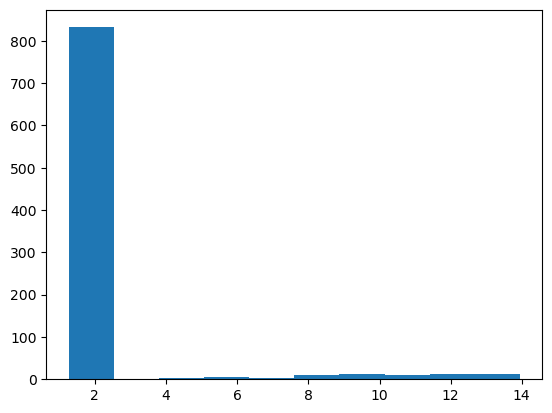

In [17]:
plt.hist(raw_g)

## Plotting assorted runs of the MCMC model for each channel

In [9]:
# import joblib
# from tqdm import tqdm
# from joblib import Parallel, delayed
# joblib.cpu_count()

# num_groups = 512
# def test(i):
#     a = 0
#     for i in range(100):
#         for j in range(i**100):
#             a += 1
#     return a
# dispersion = list(tqdm(Parallel(return_as="generator", n_jobs=-1)(delayed(test)(i) for i in range(num_groups)), total = num_groups))


In [ ]:
# dispersion_m = []

# for i in tqdm(range(1000)):
#     dispersion_m.append(dispersion_subset(i))

# dispersion_g = Parallel(n_jobs=-1)(delayed(dispersion_subset)(i) for i in tqdm(range(1000)))


 51%|█████     | 512/1000 [02:05<01:31,  5.34it/s]

In [18]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    channel = obs["i"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

mags = [min(-19,i) for i in mags]

groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))
    
stats_i, raw_i = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_i)

100%|██████████| 758/758 [02:14<00:00,  5.65it/s] 


(1.3386832, 0.045484673)


(array([ 50.,  69.,  87., 119., 108.,  88.,  72.,  52.,  26.,  13.]),
 array([1.25185061, 1.27213478, 1.29241884, 1.31270301, 1.33298707,
        1.35327125, 1.37355542, 1.39383948, 1.41412365, 1.43440771,
        1.45469189]),
 <BarContainer object of 10 artists>)

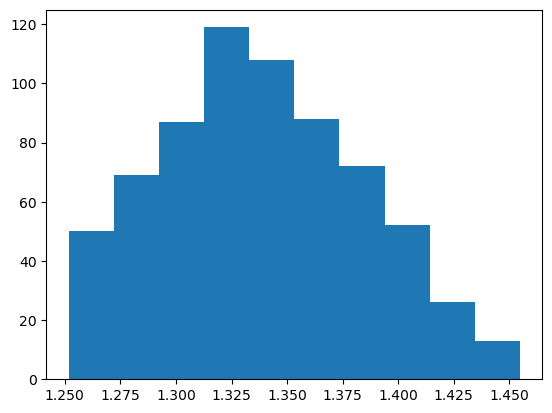

In [19]:
plt.hist(raw_i)

In [20]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    channel = obs["r"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

mags = [min(-19,i) for i in mags]

groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))
    
stats_r, raw_r = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_r)

100%|██████████| 1126/1126 [03:06<00:00,  6.02it/s]


(2.4019701, 3.3153317)


(array([912.,   0.,   1.,   4.,  10.,   9.,  13.,  20.,  23.,  22.]),
 array([ 1.23886716,  2.70324969,  4.1676321 ,  5.63201427,  7.09639692,
         8.56077957, 10.02516174, 11.48954391, 12.95392609, 14.41830921,
        15.88269138]),
 <BarContainer object of 10 artists>)

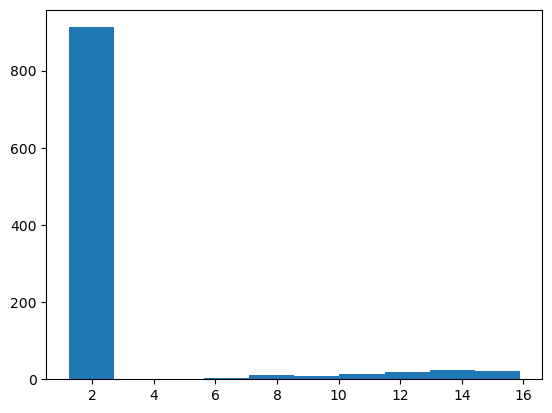

In [21]:
plt.hist(raw_r)

In [22]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    if obs["z"] <= 2.1:
        continue
    channel = obs["g"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

mags = [min(-19,i) for i in mags]

groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))
    
stats_g_zf, raw_g_zf = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_g_zf)

100%|██████████| 270/270 [00:53<00:00,  5.07it/s]

(0.99649686, 1.2330338)


(array([236.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   1.,   3.]),
 array([ 0.72612309,  1.67465162,  2.62318015,  3.57170868,  4.52023745,
         5.46876574,  6.4172945 ,  7.36582279,  8.31435108,  9.26288033,
        10.21140862]),
 <BarContainer object of 10 artists>)

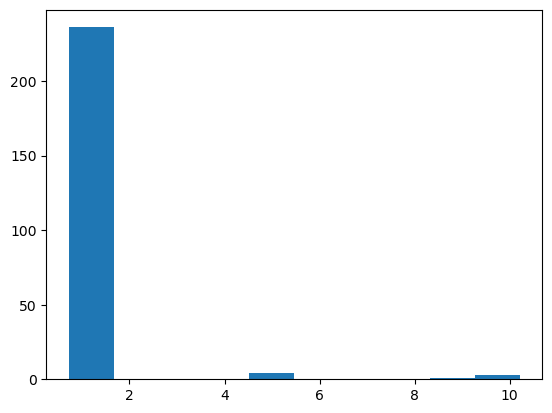

In [23]:
plt.hist(raw_g_zf)

In [24]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    if obs["z"] <= 2.1:
        continue
    channel = obs["i"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

mags = [min(-19,i) for i in mags]

groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))
    
stats_i_zf, raw_i_zf = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_i_zf)

100%|██████████| 187/187 [00:44<00:00,  4.24it/s]

(0.771263, 0.027388128)


(array([10., 15., 21., 18., 24., 25., 22., 16., 12.,  6.]),
 array([0.71771586, 0.72888774, 0.74005961, 0.75123149, 0.76240337,
        0.77357531, 0.78474718, 0.79591906, 0.80709094, 0.81826282,
        0.82943469]),
 <BarContainer object of 10 artists>)

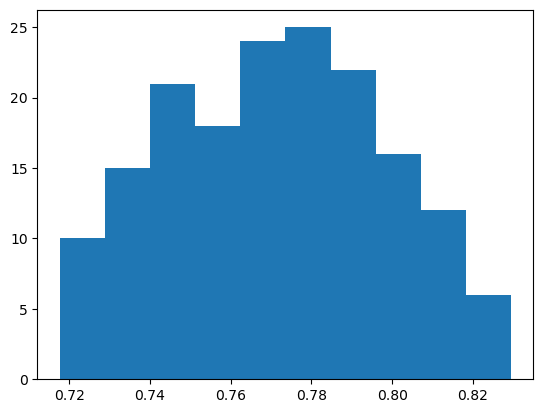

In [25]:
plt.hist(raw_i_zf)

In [26]:
mags = []
mag_err = []
dates = []

for obs in tqdm(data):
    if obs["z"] <= 2.1:
        continue
    channel = obs["r"]
    if(len(channel.keys()) == 0):
        continue
    closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    date = channel["hmjd"][0]

    mags.append(closest_date)
    mag_err.append(cerr)
    dates.append(date)

mags = [min(-19,i) for i in mags]

groups = []
for i in tqdm(range(len(mags))):
    groups.append(np.random.randint(0, 1000))
    
stats_r_zf, raw_r_zf = calculate_dispersion_with_batching(mags, mag_err, dates, 721)
print(stats_r)

100%|██████████| 303/303 [01:19<00:00,  3.80it/s]

(2.4019701, 3.3153317)


(array([266.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   3.]),
 array([ 0.77681589,  2.10701847,  3.43722105,  4.76742363,  6.09762621,
         7.42782879,  8.75803185, 10.08823395, 11.418437  , 12.74863911,
        14.07884216]),
 <BarContainer object of 10 artists>)

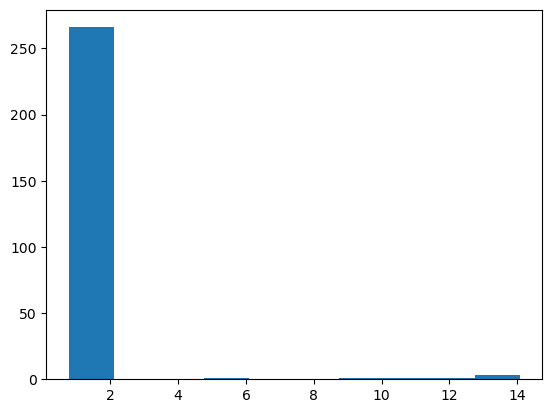

In [27]:
plt.hist(raw_r_zf)

In [28]:
print(f"g dispersion: {stats_g} (unfiltered), {stats_g_zf} (z >= 2.1)")
print(f"i dispersion: {stats_i} (unfiltered), {stats_i_zf} (z >= 2.1)")
print(f"r dispersion: {stats_r} (unfiltered), {stats_r_zf} (z >= 2.1)")

g dispersion: (2.082259, 2.425331) (unfiltered), (0.99649686, 1.2330338) (z >= 2.1)
i dispersion: (1.3386832, 0.045484673) (unfiltered), (0.771263, 0.027388128) (z >= 2.1)
r dispersion: (2.4019701, 3.3153317) (unfiltered), (1.1012447, 1.6967472) (z >= 2.1)


In [ ]:
# calc_dispersion_bayesian(mags, mag_err, dates)

/tmp/ipykernel_2033680/3311057799.py:30: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=3200, num_chains=2)
  0%|          | 0/3700 [00:00<?, ?it/s]

In [13]:
# mags = []
# mags_zf = []

# for obs in tqdm(data):
#     channel = obs["r"]
#     if(len(channel.keys()) == 0):
#         continue


#     closest_date, cerr = weightedMean(channel["mag"], channel["magerr"], channel["hmjd"])
    
#     if obs["z"] > 2.1:
#         mags_zf.append(closest_date)
#     mags.append(closest_date)

100%|██████████| 1292763/1292763 [04:24<00:00, 4879.26it/s] 
